# Algorithm Implement

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import quantstats as qs
import pandas as pd
import numpy as np
import sys
time_period = 2
sys.path.append('./')
from utlis import get_data, Stock_Env
import warnings
warnings.filterwarnings('ignore')
from collections import deque

class Actor_Critic_continuous(nn.Module):

    def __init__(self, state_size, action_size, hidden=[256, 256]):
        super(Actor_Critic_continuous, self).__init__()
        hidden = [state_size] + hidden
        self.feature = nn.ModuleList(nn.Linear(in_dim, out_dim) for in_dim, out_dim in zip(hidden[:-1], hidden[1:]))
        self.d = nn.Dropout(0.4)
        self.mu = nn.Linear(hidden[-1], action_size)
        self.logstd = nn.Linear(hidden[-1], action_size)
        self.output = nn.Linear(hidden[-1], 1)

    def forward(self, state):
        # print(state.shape)
        x = state
        for layer in self.feature:
            x = F.relu(layer(x))
        # x = self.d(x)
        mu = self.mu(x)
        logstd = self.logstd(x)
        values = self.output(x)
        # mu = (mu-mu.mean())/mu.std()
        # logstd = (logstd - logstd.mean())/logstd.std()
        # mu = mu/mu.abs().max()
        # logstd = logstd/logstd.abs().max()
        # mu = torch.clamp(mu, -1, 1)
        # logstd = torch.clamp(logstd, -1, 1)
        mu = torch.atan(mu)
        logstd = torch.atan(logstd)
        return mu, logstd, values

# Data Loading

In [2]:
stock_df_train, stock_df_test, stock_df_train_, stock_df_test_, codes = get_data()
codes_dict = dict(zip(codes, range(len(codes))))

100%|███████████████████████████████████████████████████████████████████████████████| 252/252 [00:00<00:00, 718.22it/s]


In [3]:
train_date = sorted([x[0] for x in stock_df_train.index])
test_date = sorted([x[0] for x in stock_df_test.index])

# Environment and RL model

In [4]:
class Stock_Env:
    def __init__(self, initial_asset, data, cost, time, codes, record,train=True,market=False):
        self.asset = initial_asset
        self.cash = initial_asset
        self.stock = np.zeros(len(codes))
        self.stockvalue = np.zeros(len(codes))
        self.data = data
        self.time = np.unique(time)
        self.cost = cost
        self.totalday = 0
        self.history=[]
        self.total_cost = 0
        self.initial_asset = initial_asset
        self.timeid = time_period
        self.rowid = self.time[time_period]
        self.codes = codes
        self.action_space = len(codes)+1
        self.codeid = pd.DataFrame(range(len(codes)), index=codes)
        self.record = record
        self.train=train
        self.market=market
    
    def reset(self):
        self.asset = self.initial_asset
        self.cash = self.initial_asset
        self.stock = np.zeros(len(codes))
        self.stockvalue = np.zeros(len(codes))
        self.history=[]
        self.total_cost = 0
        if self.train:
            temp_time = np.random.randint(time_period, len(self.time)-252)
        else:
            temp_time = time_period
        self.rowid = self.time[temp_time]
        self.timeid = temp_time
        self.totalday = 0
        temp = self.record.loc[self.time[temp_time+1-time_period:temp_time+1]].values
        # print(temp.shape, self.stockvalue.shape)
        temp = np.concatenate((temp, self.stockvalue/(self.asset)),axis=None)
        return temp
        # for i in range(time_period):
        #     temp.append(list(self.get_full_data(self.data.loc[self.time[temp_time-time_period+i+1]]).values.reshape(-1)))       
        # return np.array(temp)
    
    def get_full_data(self,x):
        full_df = pd.DataFrame(0, index = self.codes, columns = x.columns)
        full_df.loc[set(full_df.index).intersection(set(x.index))] = x.loc[set(full_df.index).intersection(set(x.index))]
        return full_df
    
    def step(self, action):
        done = False
        states = self.data.loc[self.rowid]        
        self.timeid +=1
        self.rowid = self.time[self.timeid]
        if (self.timeid == len(self.time)-1):
            done = True
        if (self.train==True) and (self.totalday>=252) :
            dont = True
        self.totalday+=1
        next_state = self.data.loc[self.rowid]
        last_asset = self.asset
        idx = self.codeid.loc[next_state.index].values.reshape(1,-1)
        # Calculate the total assets at the beginning of the next day
        self.stockvalue[idx] = self.stock[idx].reshape(1,-1)*next_state['open'].values.reshape(1,-1)
        old_asset = self.cash + self.stockvalue.sum()
        
        self.asset = old_asset
        # Calculate the position for each stock and cash
        action = np.exp(action)/np.exp(action).sum()
        # Get the stock asset value, where the last value of action is the position of cash.
        stockvalue_ = old_asset * (1-action[-1])
        
        # Adjust the postion
        target_value = action*old_asset
        distance = target_value[:-1] - self.stockvalue
        stock_distance = (distance[idx].reshape(-1))/((next_state['open'].values*(1+self.cost)).astype(int).reshape(-1))
        # stock_distance /= 5
        self.stock[idx] += stock_distance
        self.cash = self.cash - distance[idx].sum() - np.abs(stock_distance*self.cost*next_state['open'].values).sum()
        self.stockvalue[idx] = self.stock[idx] * next_state['close'].values
            
        # Calculate new asset
        self.asset = self.stockvalue.sum() + self.cash
        
        reward = (self.asset - last_asset)/self.initial_asset
        if self.market:
            reward -= next_state['market'].values.mean()
        
        # Generate new states
        temp = self.record.loc[self.time[self.timeid+1-time_period:self.timeid+1]].values
        temp = np.concatenate((temp, self.stockvalue/(self.asset)),axis=None)
        # print(temp.shape)
        # for i in range(time_period):
        #     temp.append(list(self.get_full_data(self.data.loc[self.time[self.timeid-time_period+i+1]]).values.reshape(-1)))
        return (temp, reward, done)
        # return (self.data[self.rowid-time_period:self.rowid][indicators].values, reward, done)

In [5]:
import torch
import torch.optim as optim
import numpy as np

import math

            
class Agent_continuous:
    
    def __init__(self, state_size, action_size, lr, beta, eps, tau, gamma, device, hidden=[256, 256], share=False, mode='MC', use_critic=False, normalize=False, personality=1, b=0.1):
        self.state_size = state_size
        self.action_size = action_size
        self.lr = lr
        self.beta = beta
        self.eps = eps
        self.tau = tau
        self.gamma = gamma
        self.device = device
        self.share = share
        self.mode = mode
        self.use_critic = use_critic
        self.normalize = normalize
        self.personality = personality
        self.b = b
        self.mu = 0
        # self.mu = [[0] * (self.action_size)]
        
        if self.share:
            self.Actor_Critic = Actor_Critic_continuous(self.state_size, self.action_size, hidden).to(self.device)
            self.optimizer = optim.Adam(self.Actor_Critic.parameters(), lr)
        else:
            self.Actor = Actor_continuous(state_size, action_size, hidden).to(self.device)
            self.Critic = Critic(state_size, hidden).to(self.device)
            self.actor_optimizer = optim.Adam(self.Actor.parameters(), lr)
            self.critic_optimizer = optim.Adam(self.Critic.parameters(), lr)
            
    # def act(self, states, test=False):
    #     with torch.no_grad():
    #         states = torch.tensor(states, dtype=torch.float).to(self.device).reshape(-1)
    #         if self.share:
    #             mu, logstd, _ = self.Actor_Critic(states)
    #         else:
    #             mu, logstd = self.Actor(states)
    #     if np.random.rand()>self.b and test: #and self.mu!=0:
    #         actions = list(states[-5:].cpu().numpy().reshape(-1)) + [1-states[-5:].cpu().numpy().reshape(-1).sum()]
    #     else:
    #         # mu = mu/mu.abs().max()
    #         # logstd = logstd/logstd.abs().max()
    #         actions = torch.distributions.Normal(mu, logstd.exp()).sample()
    #         # actions = actions/actions.abs().max()
    #         actions = actions.cpu().numpy().reshape(-1)
    #     self.mu = 0.9*self.mu + 0.1*mu.sum()
    #     return actions
        
    # def act(self, states, test=False):
    #     with torch.no_grad():
    #         states = torch.tensor(states, dtype=torch.float).to(self.device).reshape(-1)
    #         if self.share:
    #             mu, logstd, _ = self.Actor_Critic(states)
    #         else:
    #             mu, logstd = self.Actor(states)
    #         # mu = mu/mu.abs().max()
    #         # logstd = logstd/logstd.abs().max()
    #         if mu.sum()>self.mu and np.random.rand()>self.b:
    #             actions = torch.distributions.Normal(mu, logstd.exp()).sample()
    #             # actions = actions/actions.abs().max()
    #             actions = actions.cpu().numpy().reshape(-1)
    #         else:
    #             actions = list(states[-5:].cpu().numpy().reshape(-1)) + [1-states[-5:].cpu().numpy().reshape(-1).sum()]
    #         self.mu = 0.9*self.mu + 0.1*mu.sum()
    #     return actions
    
    def act(self, states, test=False):
        with torch.no_grad():
            states = torch.tensor(states, dtype=torch.float).to(self.device).reshape(-1)
            if self.share:
                mu, logstd, _ = self.Actor_Critic(states)
            else:
                mu, logstd = self.Actor(states)
            # mu = mu/mu.abs().max()
            # logstd = logstd/logstd.abs().max()
            if mu.sum()>self.mu:
                actions = torch.distributions.Normal(mu, logstd.exp()).sample()
                # actions = actions/actions.abs().max()
                actions = actions.cpu().numpy().reshape(-1)
            else:
                actions = list(states[-5:].cpu().numpy().reshape(-1)) + [1-states[-5:].cpu().numpy().reshape(-1).sum()]
            self.mu = 0.9*self.mu + 0.1*mu.sum()
        return actions

    # def act(self, states):
    #     with torch.no_grad():
    #         states = torch.tensor(states, dtype=torch.float).to(self.device).reshape(-1)
    #         if self.share:
    #             mu, logstd, _ = self.Actor_Critic(states)
    #         else:
    #             mu, logstd = self.Actor(states)
    #         # mu = mu/mu.abs().max()
    #         # logstd = logstd/logstd.abs().max()
    #         # print(self.mu)
    #         if np.abs(mu.cpu().numpy()).sum()>np.abs(np.mean(self.mu,axis=0) + 2*np.std(self.mu, axis=0)).sum() or np.abs(mu.cpu().numpy()).sum()<np.abs(np.mean(self.mu,axis=0) - 2*np.std(self.mu, axis=0)).sum():
    #             actions = torch.distributions.Normal(mu, logstd.exp()).sample()
    #             # actions = actions/actions.abs().max()
    #             actions = actions.cpu().numpy().reshape(-1)
    #         else:
    #             actions = list(states[-5:].cpu().numpy().reshape(-1)) + [1-states[-5:].cpu().numpy().reshape(-1).sum()]
    #         self.mu.append(list(mu.cpu().numpy().reshape(-1)))
    #         if len(self.mu)>100:
    #             self.mu = self.mu[-100:]
    #     return actions
    
    # def act(self, states):
    #     with torch.no_grad():
    #         states = torch.tensor(states, dtype=torch.float).to(self.device).reshape(-1)
    #         if self.share:
    #             mu, logstd, _ = self.Actor_Critic(states)
    #         else:
    #             mu, logstd = self.Actor(states)
    #         # mu = mu/mu.abs().max()
    #         # # logstd = logstd/logstd.abs().max()
    #         # print(self.mu)
    #         # print(np.abs(mu.cpu().numpy()))
    #         # print(np.abs(np.mean(self.mu,axis=0)))
    #         if np.abs(mu.cpu().numpy()).sum()>np.abs(np.mean(self.mu,axis=0)).sum():
    #             actions = torch.distributions.Normal(mu, logstd.exp()).sample()
    #             # actions = actions/actions.abs().max()
    #             actions = actions.cpu().numpy().reshape(-1)
    #         else:
    #             actions = list(states[-5:].cpu().numpy().reshape(-1)) + [1-states[-5:].cpu().numpy().reshape(-1).sum()]
    #         self.mu.append(list(mu.cpu().numpy().reshape(-1)))
    #         if len(self.mu)>25:
    #             self.mu = self.mu[-25:]
    #     return actions
    
    def process_data(self, states, actions, rewards, dones, batch_size):
        states = torch.tensor(states, dtype=torch.float).to(self.device)
        states = states.reshape([-1, 15*2+5])
        actions.append(np.zeros(self.action_size))
        states = torch.tensor(states, dtype=torch.float).to(self.device)
        actions = torch.tensor(actions, dtype=torch.float).to(self.device).view(-1, self.action_size)
        dones = torch.tensor(dones, dtype=torch.float).to(self.device).view(-1, 1)
        
        #calculate log probabilities and state values
        N = states.size(0) # N-1 is the length of actions, rewards and dones
        log_probs = torch.zeros((N, self.action_size)).to(self.device)
        old_mu = torch.zeros((N, self.action_size)).to(self.device)
        old_logstd = torch.zeros((N, self.action_size)).to(self.device)
        step = math.ceil(N/batch_size)
        
        for ind in range(step):
            if self.share:
                mu, logstd, _ = self.Actor_Critic(states[ind*batch_size:(ind+1)*batch_size, :])
            else:
                mu, logstd = self.Actor(states[ind*batch_size:(ind+1)*batch_size, :])
            # mu = mu/mu.abs().max()
            # logstd = logstd/logstd.abs().max()
            distribution = torch.distributions.normal.Normal(mu, logstd.exp())
            log_probs[ind*batch_size:(ind+1)*batch_size, :] = distribution.log_prob(actions[ind*batch_size:(ind+1)*batch_size, :])
            # log_probs = log_probs/log_probs.abs().max()
            old_mu[ind*batch_size:(ind+1)*batch_size, :] = mu
            old_logstd[ind*batch_size:(ind+1)*batch_size, :] = logstd 
            
        log_probs = log_probs[:-1, :]# remove the last one, which corresponds to no actions
        old_mu = old_mu[:-1, :]
        old_logstd = old_logstd[:-1, :]
        actions = actions[:-1, :]
        log_probs = log_probs.sum(dim=1, keepdim=True)

        rewards = np.array(rewards) #r_t
        
        return states, actions, old_mu.detach(), old_logstd.detach(), log_probs.detach(), rewards, dones
    
    def learn(self, states, actions, old_mu, old_logstd, log_probs, rewards, dones):
        # print(states, actions, old_mu, old_logstd, log_probs, rewards, dones)
        rewards[rewards<0] = rewards[rewards<0]*self.personality
        if self.share:
            new_mu, new_logstd, state_values = self.Actor_Critic(states)
            new_mu = new_mu[:-1, :]
            new_logstd = new_logstd[:-1, :]
        else:
            new_mu, new_logstd = self.Actor(states)
            new_mu = new_mu[:-1, :]
            new_logstd = new_logstd[:-1, :]
            state_values = self.Critic(states)
        
        # new_mu = new_mu/new_mu.abs().max()
        # new_logstd = new_logstd/new_logstd.abs().max()
        new_distribution = torch.distributions.normal.Normal(new_mu, new_logstd.exp())
        new_log_probs = new_distribution.log_prob(actions)
        # new_log_probs = new_log_probs/new_log_probs.abs().max()
        new_log_probs = new_log_probs.sum(dim=1, keepdim=True)
        
        KL = new_logstd - old_logstd + (old_logstd.exp().pow(2) + (new_mu - old_mu).pow(2))/(2*new_logstd.exp().pow(2) + 1e-6) - 0.5
        KL = KL.sum(dim=1, keepdim=True)
        
        L = rewards.shape[0]
        with torch.no_grad():
            G = []
            return_value = 0
            if self.mode == 'MC':
                for i in range(L-1, -1, -1):
                    return_value = rewards[i] + self.gamma * return_value * (1-dones[i])
                    G.append(return_value)
                G = G[::-1]
                G = torch.tensor(G, dtype=torch.float).view(-1, 1).to(self.device)
            else:
                rewards = torch.tensor(rewards, dtype=torch.float).view(-1, 1).to(self.device)
                G = rewards + (1 - dones) * self.gamma * state_values[1:, :]
            
        Critic_Loss = 0.5*(state_values[:-1, :] - G).pow(2).mean()
        with torch.no_grad():
            if self.use_critic:
                G = G - state_values[:-1, :] # advantage
            for i in range(L-2, -1, -1):
                G[i] += G[i+1]*self.gamma*(1-dones[i])*self.tau # cumulated advantage
            if self.normalize:
                G = (G - G.mean()) / (G.std() + 0.00001)
        
        ratio = (new_log_probs - log_probs).exp()
        Actor_Loss1 = ratio * G
        Actor_Loss2 = torch.clamp(ratio, 1-self.eps, 1+self.eps) * G
        Actor_Loss = -torch.min(Actor_Loss1, Actor_Loss2)
        Actor_Loss += self.beta * KL

        Actor_Loss = Actor_Loss.mean()
        
        if self.share:
            Loss = Actor_Loss + Critic_Loss
            self.optimizer.zero_grad()
            Loss.backward()
            torch.nn.utils.clip_grad_norm_(self.Actor_Critic.parameters(), 1)
            self.optimizer.step()
        else:
            self.critic_optimizer.zero_grad()
            Critic_Loss.backward()
            torch.nn.utils.clip_grad_norm_(self.Critic.parameters(), 1)
            self.critic_optimizer.step()
            self.actor_optimizer.zero_grad()
            Actor_Loss.backward()
            torch.nn.utils.clip_grad_norm_(self.Actor.parameters(), 1)
            self.actor_optimizer.step()

In [6]:
# agent = Agent(1, len(env.action_space), 0.0005, 0.99, 'cuda', 'TD', True, False)
env = Stock_Env(1000000, stock_df_train, 0.001, [x[0] for x in stock_df_train.index], codes, stock_df_train_,train=True,market=False)
env_test = Stock_Env(1000000, stock_df_test, 0.001, [x[0] for x in stock_df_test.index], codes, stock_df_test_,train=False, market=False)
agent = Agent_continuous(state_size=15*2+5, 
                             action_size=env.action_space, 
                             lr=0.001, 
                             beta=1, 
                             eps=0.1, 
                             tau=0.99, 
                             gamma=0.99, 
                             device='cuda',
                             share=True, 
                             mode='TD', 
                             use_critic=True, 
                             normalize=False,
                             hidden = [16,16],
                             personality = 1,
                             b = 0.1)

In [7]:
import warnings
warnings.filterwarnings('ignore')
#env = gym.make()
num_episode = 20000
max_t = 1000
reward_log = []
average_log = [] # monitor training process
eps = 1
eps_decay = 0.997
eps_min = 0.01
num_frame = 1
C = 4 # update weights every C steps
state_deque = deque(maxlen=1)

def validation(env, agent):
    # agent.mu=0
    rewards_log = []
    average_log = []
    episodic_reward = 0
    done = False
    t = 0
    state = env.reset()
    while not done and t < max_t:
        t += 1
        action = agent.act(state.reshape([1]+list(state.shape)),test=True)
        frame, reward, done = env.step(action)
        next_state = frame
        state = next_state.copy()
        episodic_reward += reward
        reward_log = rewards_log.append(reward)
    sharpe = qs.stats.sharpe(pd.DataFrame(rewards_log))
    return env.asset, episodic_reward, sharpe


rewards_log = []
average_log = []
state_history = []
action_history = []
done_history = []
reward_history = []
validation_log = []
validation_average_log = []
sharpe_log = []
average_sharpe = []
def train(agent, env, n_episode, n_update=4, update_frequency=1, max_t=1500, scale=1):
    global rewards_log, average_log, state_history, action_history, done_history, reward_history
    for i in range(1, 1 + num_episode):
        # agent.mu=0
        episodic_reward = 0
        done = False
        frame = env.reset()
        # state_deque = deque(maxlen=num_frame)
        for _ in range(num_frame):
            state_deque.append(frame)
        state = np.stack(state_deque, axis=0)
        # state = np.expand_dims(state, axis=0)
        
        done = False
        t = 0
        
        if len(state_history) == 0:
            state_history.append(state)
        else:
            state_history[-1] = state

        while not done and t < max_t:
            action = agent.act(state, test=True)
            frame, reward, done = env.step(action)
            state_deque.append(frame)
            next_state = np.stack(state_deque, axis=0)
            # next_state = np.expand_dims(next_state, axis=0)
           
            episodic_reward += reward
            action_history.append(action)
            done_history.append(done)
            reward_history.append(reward * scale)
            state = next_state.copy()
            state_history.append(state)
            t += 1
            
            
        if i % update_frequency == 0:
            states, actions, old_mu, old_logstd, log_probs, rewards, dones = agent.process_data(state_history, action_history, reward_history, done_history, 64)
            # print(states, actions, old_mu, old_logstd, log_probs, rewards, dones)
            for _ in range(n_update):
                agent.learn(states, actions, old_mu, old_logstd, log_probs, rewards, dones)
            state_history = []
            action_history = []
            done_history = []
            reward_history = []
        
        rewards_log.append(episodic_reward)
        average_log.append(np.mean(rewards_log[-100:]))
        
        val_asset, val_reward, val_sharpe = validation(env_test, agent)

        validation_log.append(val_reward)
        validation_average_log.append(np.mean(validation_log[-100:]))
        sharpe_log.append(val_sharpe.values[0])
        average_sharpe.append(np.mean(sharpe_log[-100:]))
        print('\rEpisode {}, Reward {:.3f}, Average Reward {:.3f}, valReward {:.3f}, val Average Reward {:.3f}, Asset {:.2f}, Validation Asset {:.2f}, Average Validation Sharpe {:.2f}'.format(i, episodic_reward, average_log[-1], val_reward, validation_average_log[-1], env.asset, val_asset, average_sharpe[-1]), end='')
        # print('\rEpisode {}, Reward {:.3f}, Average Reward {:.3f}, Asset {:.2f}, Validation Asset {:.2f}'.format(i, episodic_reward, average_log[-1], env.asset, val_asset), end='')
        if i % 100 == 0:
            print()
        
    return rewards, average_log

In [8]:
# rewards_log, _ = train(agent, env, 2000, max_t, 10)
rewards_log, _ = train(agent=agent, 
                       env=env, 
                       n_episode=2000, 
                       n_update=10, 
                       update_frequency=1, 
                       max_t=2000, 
                       scale=1)

Episode 100, Reward -0.044, Average Reward 0.043, valReward 0.266, val Average Reward 0.212, Asset 955991.59, Validation Asset 1265741.95, Average Validation Sharpe 1.12
Episode 200, Reward -0.059, Average Reward 0.071, valReward 0.143, val Average Reward 0.223, Asset 941174.81, Validation Asset 1143483.25, Average Validation Sharpe 1.16
Episode 300, Reward 0.186, Average Reward 0.093, valReward 0.161, val Average Reward 0.241, Asset 1185662.87, Validation Asset 1160886.55, Average Validation Sharpe 1.26
Episode 400, Reward 0.003, Average Reward 0.114, valReward 0.303, val Average Reward 0.250, Asset 1002787.35, Validation Asset 1302909.84, Average Validation Sharpe 1.30
Episode 500, Reward 0.112, Average Reward 0.121, valReward 0.218, val Average Reward 0.251, Asset 1112416.35, Validation Asset 1218163.92, Average Validation Sharpe 1.30
Episode 600, Reward 0.154, Average Reward 0.128, valReward 0.338, val Average Reward 0.267, Asset 1153594.38, Validation Asset 1337741.70, Average Val

KeyboardInterrupt: 

Text(0, 0.5, 'Average Return')

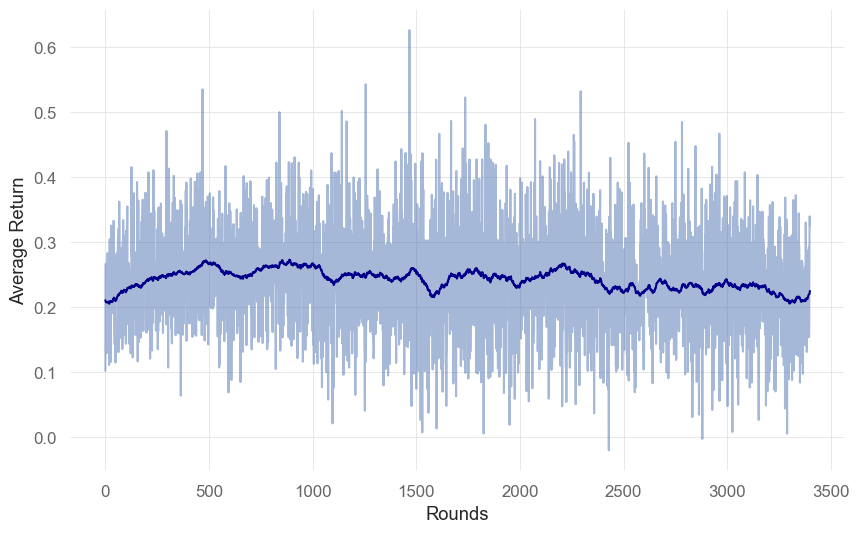

In [11]:
import matplotlib.pyplot as plt
# plt.plot(validation_log[:800])
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(validation_log[100:3500],alpha=0.5)

ax.plot(validation_average_log[100:3500], 'darkblue')
ax.set_xlabel('Rounds')
ax.set_ylabel('Average Return')